In [1]:
import sys
sys.path.append('./../../')

import os
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
import argparse
from config_reader import ConfigReader
from modules.dvae.model import DVAE
from modules.vqvae.model import VQVAE
from datasets.mnist_loader import MNISTData
from datasets.cub_loader import CUBData

from modules.common_utils import latent_to_img
from notebooks.utils import show

In [2]:
config_folder_path = '/u/82/sukhoba1/unix/Desktop/TA-VQVAE/configs/'

config_path_vqvae_vs = config_folder_path + 'comparison_vqvae_cub128_v512_ds2_vocabsep.yaml'
config_path_vqvae_jo = config_folder_path + 'comparison_vqvae_cub128_v512_ds2_jointopt.yaml'
config_path_dvae = config_folder_path + 'comparison_dvae_cub128_v512_ds2.yaml'
config_path_dvae_fkl = config_folder_path + 'comparison_dvae_cub128_v512_ds2_fixed_kl.yaml'

CONFIG_vqvae_vs = ConfigReader(config_path=config_path_vqvae_vs)
CONFIG_vqvae_jo = ConfigReader(config_path=config_path_vqvae_jo)
CONFIG_dvae = ConfigReader(config_path=config_path_dvae)
CONFIG_dvae_fkl = ConfigReader(config_path=config_path_dvae_fkl)

In [3]:
data_source = CUBData(
    img_type=CONFIG_vqvae_vs.dataset_type,
    root_path=CONFIG_vqvae_vs.root_path,
    batch_size=CONFIG_vqvae_vs.BATCH_SIZE,
    prct_train_split=0.99,
    custom_transform_version=CONFIG_vqvae_vs.custom_transform_version)

train_loader = data_source.get_train_loader(batch_size=4)

In [4]:
vqvae_vs = VQVAE(
    img_channels=CONFIG_vqvae_vs.in_channels,
    num_embeddings=CONFIG_vqvae_vs.vocab_size,
    embedding_dim=CONFIG_vqvae_vs.vqvae_embedding_dim,
    commitment_cost=CONFIG_vqvae_vs.vqvae_commitment_cost,
    decay=CONFIG_vqvae_vs.vqvae_decay,
    num_x2downsamples=CONFIG_vqvae_vs.num_x2downsamples,
    num_resid_downsample_layers=CONFIG_vqvae_vs.num_resids_downsample,
    num_resid_bottleneck_layers=CONFIG_vqvae_vs.num_resids_bottleneck,
    use_batch_norm=True,
    use_conv1x1=True)

vqvae_vs.eval()
vqvae_vs.load_model(
    root_path=CONFIG_vqvae_jo.save_model_path,
    model_name=CONFIG_vqvae_jo.save_model_name)

In [5]:
vqvae_jo = VQVAE(
    img_channels=CONFIG_vqvae_jo.in_channels,
    num_embeddings=CONFIG_vqvae_jo.vocab_size,
    embedding_dim=CONFIG_vqvae_jo.vqvae_embedding_dim,
    commitment_cost=CONFIG_vqvae_jo.vqvae_commitment_cost,
    decay=CONFIG_vqvae_jo.vqvae_decay,
    num_x2downsamples=CONFIG_vqvae_jo.num_x2downsamples,
    num_resid_downsample_layers=CONFIG_vqvae_jo.num_resids_downsample,
    num_resid_bottleneck_layers=CONFIG_vqvae_jo.num_resids_bottleneck,
    use_batch_norm=True,
    use_conv1x1=True)

vqvae_jo.eval()
vqvae_jo.load_model(
    root_path=CONFIG_vqvae_jo.save_model_path,
    model_name=CONFIG_vqvae_jo.save_model_name)

In [6]:
dvae = DVAE(
    in_channels=CONFIG_dvae.in_channels,
    vocab_size=CONFIG_dvae.vocab_size,
    num_x2downsamples=CONFIG_dvae.num_x2downsamples,
    num_resids_downsample=CONFIG_dvae.num_resids_downsample,
    num_resids_bottleneck=CONFIG_dvae.num_resids_bottleneck,
    hidden_dim=CONFIG_dvae.hidden_dim)

dvae.eval()
dvae.load_model(
    root_path=CONFIG_dvae.save_model_path,
    model_name=CONFIG_dvae.save_model_name)

In [ ]:
dvae_fkl = DVAE(
    in_channels=CONFIG_dvae_fkl.in_channels,
    vocab_size=CONFIG_dvae_fkl.vocab_size,
    num_x2downsamples=CONFIG_dvae_fkl.num_x2downsamples,
    num_resids_downsample=CONFIG_dvae_fkl.num_resids_downsample,
    num_resids_bottleneck=CONFIG_dvae_fkl.num_resids_bottleneck,
    hidden_dim=CONFIG_dvae_fkl.hidden_dim)

dvae_fkl.eval()
dvae_fkl.load_model(
    root_path=CONFIG_dvae_fkl.save_model_path,
    model_name=CONFIG_dvae_fkl.save_model_name)

In [14]:
img, _ = next(iter(train_loader))

In [15]:
'076.Dark_eyed_Junco/Dark_Eyed_Junco_0011_66280.jpg'

'076.Dark_eyed_Junco/Dark_Eyed_Junco_0011_66280.jpg'

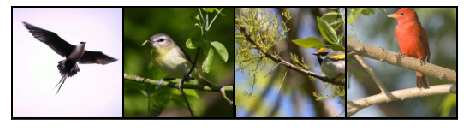

In [16]:
show(img)

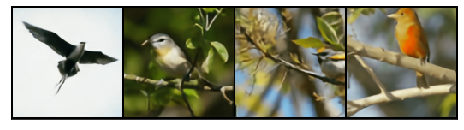

In [17]:
recon_vqvae_vs = vqvae_vs.get_reconstruction(img)
show(recon_vqvae_vs)

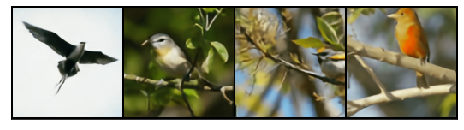

In [18]:
recon_vqvae_jo = vqvae_jo.get_reconstruction(img)
show(recon_vqvae_jo)

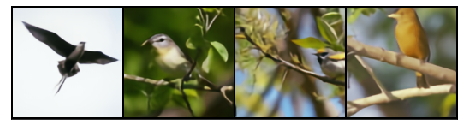

In [19]:
recon_dvae = dvae.get_reconstruction(img)
show(recon_dvae)